## EPL Data from link
https://github.com/tara-nguyen/english-premier-league-datasets-for-10-seasons

Description: EPL data of 10 seasons, with half time & full time score information for each game w/ dates.

Aim: To explore the dataset & train a model to be able to predict the outcome of a new game played b/w the teams.



In [1]:
# libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import bqplot as bq
#pip install side-by-side
from side_by_side import print_side_by_side

from pandas.api.types import CategoricalDtype
from sklearn import multioutput
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, classification_report

from sklearn.utils import compute_class_weight
import json as js


In [2]:
%matplotlib inline

In [3]:
plt.style.use('classic')
pd.options.display.float_format = '{:.1f}'.format

df = pd.read_csv('epl-allseasons-matchstats.csv')
display(df.head(2), df.tail(2))

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,2010/11,2010-08-14,M Dean,Aston Villa,West Ham,HomeWin,HomeWin,3,2,23,...,1,0,0,0,12,2,7,15,2,0
1,2010/11,2010-08-14,P Dowd,Blackburn,Everton,HomeWin,HomeWin,1,1,7,...,2,0,0,0,17,12,3,14,1,0


,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
3798,2019/20,2020-07-26,P Bankes,Southampton,Sheffield United,HomeWin,AwayWin,3,0,13,...,0,0,1,1,5,3,1,16,1,0
3799,2019/20,2020-07-26,M Oliver,West Ham,Aston Villa,Draw,Draw,1,0,10,...,2,0,1,0,13,4,7,13,1,0


In [4]:
display(df.dtypes)
display(df.shape)

Season               object
Date                 object
Referee              object
HomeTeam             object
AwayTeam             object
FullTime             object
Halftime             object
HomeGoals             int64
HomeGoalsHalftime     int64
HomeShots             int64
HomeShotsOnTarget     int64
HomeCorners           int64
HomeFouls             int64
HomeYellowCards       int64
HomeRedCards          int64
AwayGoals             int64
AwayGoalsHalftime     int64
AwayShots             int64
AwayShotsOnTarget     int64
AwayCorners           int64
AwayFouls             int64
AwayYellowCards       int64
AwayRedCards          int64
dtype: object

(3800, 23)

In [5]:
display(np.sum(df.isnull()))

Season               0
Date                 0
Referee              0
HomeTeam             0
AwayTeam             0
FullTime             0
Halftime             0
HomeGoals            0
HomeGoalsHalftime    0
HomeShots            0
HomeShotsOnTarget    0
HomeCorners          0
HomeFouls            0
HomeYellowCards      0
HomeRedCards         0
AwayGoals            0
AwayGoalsHalftime    0
AwayShots            0
AwayShotsOnTarget    0
AwayCorners          0
AwayFouls            0
AwayYellowCards      0
AwayRedCards         0
dtype: int64

In [6]:
df.Season = pd.Categorical(df.Season)
df.HomeTeam = pd.Categorical(df.HomeTeam)
df.Referee = pd.Categorical(df.Referee)
df.AwayTeam = pd.Categorical(df.AwayTeam)
df.FullTime = pd.Categorical(df.FullTime)
df.Halftime = pd.Categorical(df.Halftime)

In [7]:
cat = CategoricalDtype(categories=df.Season.unique(), ordered = True)
df.Season = df.Season.astype(cat);df.Season.unique() # since we are going to make predictions at some point, it serves better to have an ordered category of seasons based on relevance.

['2010/11', '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20']
Categories (10, object): ['2010/11' < '2011/12' < '2012/13' < '2013/14' ... '2016/17' < '2017/18' < '2018/19' < '2019/20']

In [8]:
categorical = df.iloc[:,[0,2,3,4,5,6]]
display(categorical.head(2))

,Season,Referee,HomeTeam,AwayTeam,FullTime,Halftime
0,2010/11,M Dean,Aston Villa,West Ham,HomeWin,HomeWin
1,2010/11,P Dowd,Blackburn,Everton,HomeWin,HomeWin


In [9]:
display('Number of categories for categorical columns',
        {df.columns[i]: df.iloc[:,i].cat.categories.nunique() for i in np.array([0,2,3,4,5,6])})

'Number of categories for categorical columns'

{'Season': 10,
 'Referee': 35,
 'HomeTeam': 36,
 'AwayTeam': 36,
 'FullTime': 3,
 'Halftime': 3}

In [10]:
df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)

In [11]:
display(df.Date.dtype, df.Date.head(2)) 

dtype('<M8[ns]')

0   2010-08-14
1   2010-08-14
Name: Date, dtype: datetime64[ns]

In [12]:
df.dtypes

Season                     category
Date                 datetime64[ns]
Referee                    category
HomeTeam                   category
AwayTeam                   category
FullTime                   category
Halftime                   category
HomeGoals                     int64
HomeGoalsHalftime             int64
HomeShots                     int64
HomeShotsOnTarget             int64
HomeCorners                   int64
HomeFouls                     int64
HomeYellowCards               int64
HomeRedCards                  int64
AwayGoals                     int64
AwayGoalsHalftime             int64
AwayShots                     int64
AwayShotsOnTarget             int64
AwayCorners                   int64
AwayFouls                     int64
AwayYellowCards               int64
AwayRedCards                  int64
dtype: object

#### visualize club goals over seasons.

In [13]:
hometeam = df.groupby('HomeTeam')['HomeGoals'].sum().sort_values(ascending =False)
hometeam.head(7)

HomeTeam
Man City      496
Liverpool     407
Arsenal       398
Chelsea       386
Man United    380
Tottenham     351
Everton       316
Name: HomeGoals, dtype: int64

In [14]:
awayteam = df.groupby('AwayTeam')['AwayGoals'].sum().sort_values(ascending=False);
awayteam.head(7)

AwayTeam
Man City      362
Liverpool     322
Tottenham     306
Chelsea       305
Arsenal       304
Man United    301
Everton       212
Name: AwayGoals, dtype: int64

In [15]:
viz_df1 = pd.merge(hometeam, awayteam, left_index= True, right_index=True)
viz_df1 = viz_df1.head(20); viz_df1.head()

,HomeGoals,AwayGoals
Man City,496,362
Liverpool,407,322
Arsenal,398,304
Chelsea,386,305
Man United,380,301


[]

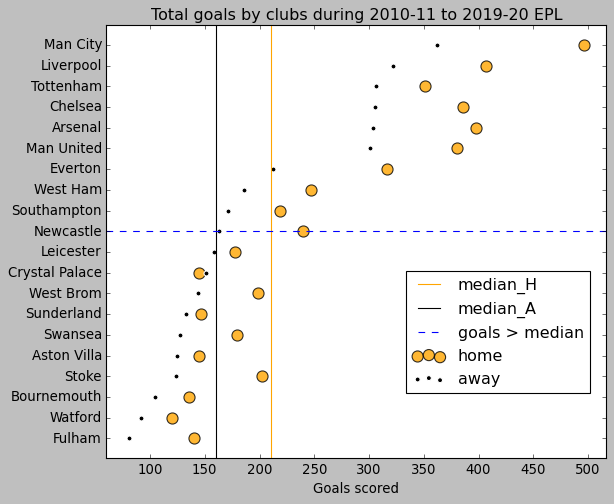

In [16]:
viz_df1.sort_values(by= 'AwayGoals',inplace=True)

plt.scatter(y = viz_df1.index, x = viz_df1.HomeGoals, c= 'orange', edgecolors='black', label= 'home', s=100, \
           alpha = 0.8)
plt.scatter(y = viz_df1.index, x = viz_df1.AwayGoals, c= 'black', edgecolors='white', label= 'away')
#plt.barh(viz_df1.index, viz_df1.AwayGoals, color= 'black', alpha = 0.1, linewidth=0)
plt.tight_layout()
plt.xlabel('Goals scored')
plt.xticks(ticks=np.arange(50,550,step=50))
median= np.median(viz_df1.iloc[:,:], axis=0) # computes median val traversing all rows 
plt.axvline(x = median[0], label= 'median_H', c='orange')
plt.axvline(x = median[1], label= 'median_A', c='black')
#plt.fill_betweenx(y = viz_df1.index,x1 = viz_df1.HomeGoals, x2= viz_df1.AwayGoals, where = (median < viz_df1.AwayGoals), alpha = 0.1)
plt.title('Total goals by clubs during 2010-11 to 2019-20 EPL')

cond1 = viz_df1.index == (viz_df1.index[median[1] < viz_df1.AwayGoals][0]) #[0] picks min value from sorted array
cond2 = viz_df1.index == (viz_df1.index[median[0] < viz_df1.HomeGoals][0]) 

y1 = int(np.argwhere((cond1) & (cond2)))
plt.axhline(y = y1, linestyle='dashed', label = 'goals > median')

#plt.fill_between(np.transpose(viz_df1.AwayGoals[viz_df1.AwayGoals > median].values), np.arange(y1,0,-1))
plt.legend(loc=(0.6,0.15))
plt.plot()

In [17]:
# select clubs 
home = df.pivot_table(values= ['HomeGoals','HomeGoalsHalftime'], columns= 'Season', index = 'HomeTeam', sort=True, aggfunc='median')
print(home.shape, home.head(3)) # NaNs indicate these clubs did not play that season. 

(36, 20)             HomeGoals                                                          \
Season        2010/11 2011/12 2012/13 2013/14 2014/15 2015/16 2016/17 2017/18   
HomeTeam                                                                        
Arsenal           2.0     1.0     2.0     2.0     2.0     2.0     2.0     3.0   
Aston Villa       1.0     1.0     1.0     1.0     1.0     1.0     NaN     NaN   
Birmingham        1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                            HomeGoalsHalftime                                  \
Season      2018/19 2019/20           2010/11 2011/12 2012/13 2013/14 2014/15   
HomeTeam                                                                        
Arsenal         2.0     2.0               0.0     1.0     1.0     1.0     1.0   
Aston Villa     NaN     1.0               1.0     0.0     0.0     0.0     1.0   
Birmingham      NaN     NaN               0.0     NaN     NaN     NaN     NaN   

                 

In [18]:
home.dropna(inplace =True, how='any') # default 'any' drops if a club did not play even a single season 

In [19]:
display(f'{home.index.nunique()} teams that were not relegated in the last 10 seasons')
home.index.values

'7 teams that were not relegated in the last 10 seasons'

['Arsenal', 'Chelsea', 'Everton', 'Liverpool', 'Man City', 'Man United', 'Tottenham']
Categories (36, object): ['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', ..., 'West Brom', 'West Ham', 'Wigan', 'Wolves']

In [20]:
print(home.columns)
print(type(home))

MultiIndex([(        'HomeGoals', '2010/11'),
            (        'HomeGoals', '2011/12'),
            (        'HomeGoals', '2012/13'),
            (        'HomeGoals', '2013/14'),
            (        'HomeGoals', '2014/15'),
            (        'HomeGoals', '2015/16'),
            (        'HomeGoals', '2016/17'),
            (        'HomeGoals', '2017/18'),
            (        'HomeGoals', '2018/19'),
            (        'HomeGoals', '2019/20'),
            ('HomeGoalsHalftime', '2010/11'),
            ('HomeGoalsHalftime', '2011/12'),
            ('HomeGoalsHalftime', '2012/13'),
            ('HomeGoalsHalftime', '2013/14'),
            ('HomeGoalsHalftime', '2014/15'),
            ('HomeGoalsHalftime', '2015/16'),
            ('HomeGoalsHalftime', '2016/17'),
            ('HomeGoalsHalftime', '2017/18'),
            ('HomeGoalsHalftime', '2018/19'),
            ('HomeGoalsHalftime', '2019/20')],
           names=[None, 'Season'])
<class 'pandas.core.frame.DataFrame'>


In [21]:
home['HomeGoals']['2019/20'] #median goals per season
home.reset_index

<bound method DataFrame.reset_index of            HomeGoals                                                          \
Season       2010/11 2011/12 2012/13 2013/14 2014/15 2015/16 2016/17 2017/18   
HomeTeam                                                                       
Arsenal          2.0     1.0     2.0     2.0     2.0     2.0     2.0     3.0   
Chelsea          2.0     2.0     2.0     2.0     2.0     2.0     3.0     1.0   
Everton          2.0     1.0     2.0     2.0     1.0     2.0     2.0     1.0   
Liverpool        2.0     1.0     1.0     3.0     2.0     1.0     2.0     2.0   
Man City         1.0     3.0     2.0     3.0     2.0     2.0     2.0     3.0   
Man United       2.0     2.0     2.0     1.0     2.0     1.0     1.0     2.0   
Tottenham        2.0     2.0     2.0     1.0     2.0     2.0     2.0     1.0   

                           HomeGoalsHalftime                                  \
Season     2018/19 2019/20           2010/11 2011/12 2012/13 2013/14 2014/15   


- multilabel classification? regression. if classification make goals as categories.
- make boxplot for 2nd viz, x = teams , y = Goals.
- see median goal progression for different seasons.


In [22]:
display(df.dtypes)
display(df.shape)
display(df.head(1))

Season                     category
Date                 datetime64[ns]
Referee                    category
HomeTeam                   category
AwayTeam                   category
FullTime                   category
Halftime                   category
HomeGoals                     int64
HomeGoalsHalftime             int64
HomeShots                     int64
HomeShotsOnTarget             int64
HomeCorners                   int64
HomeFouls                     int64
HomeYellowCards               int64
HomeRedCards                  int64
AwayGoals                     int64
AwayGoalsHalftime             int64
AwayShots                     int64
AwayShotsOnTarget             int64
AwayCorners                   int64
AwayFouls                     int64
AwayYellowCards               int64
AwayRedCards                  int64
dtype: object

(3800, 23)

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,2010/11,2010-08-14,M Dean,Aston Villa,West Ham,HomeWin,HomeWin,3,2,23,...,1,0,0,0,12,2,7,15,2,0


### Creating X & Y for model fitting

In [23]:
#X = df.drop(columns= ['Season', 'Date', 'Referee','FullTime','Halftime','HomeGoals','HomeGoalsHalftime','AwayGoals', 'AwayGoalsHalftime'])
X = df.drop(columns= ['Season', 'Date', 'Referee','HomeGoals','HomeGoalsHalftime','AwayGoals', 'AwayGoalsHalftime'])

In [24]:
X.columns

Index(['HomeTeam', 'AwayTeam', 'FullTime', 'Halftime', 'HomeShots',
       'HomeShotsOnTarget', 'HomeCorners', 'HomeFouls', 'HomeYellowCards',
       'HomeRedCards', 'AwayShots', 'AwayShotsOnTarget', 'AwayCorners',
       'AwayFouls', 'AwayYellowCards', 'AwayRedCards'],
      dtype='object')

In [25]:
y = df.loc[:][['HomeGoals','AwayGoals']]

In [26]:
display(X.head(),y.head())

,HomeTeam,AwayTeam,FullTime,Halftime,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,Aston Villa,West Ham,HomeWin,HomeWin,23,11,16,15,1,0,12,2,7,15,2,0
1,Blackburn,Everton,HomeWin,HomeWin,7,2,1,19,2,0,17,12,3,14,1,0
2,Bolton,Fulham,Draw,Draw,13,9,4,12,1,0,12,7,8,13,3,0
3,Chelsea,West Brom,HomeWin,HomeWin,18,13,3,10,1,0,10,4,1,10,0,0
4,Sunderland,Birmingham,Draw,HomeWin,6,2,3,13,3,1,13,7,6,10,3,0


,HomeGoals,AwayGoals
0,3,0
1,1,0
2,0,0
3,6,0
4,2,2


In [27]:
X.dtypes

HomeTeam             category
AwayTeam             category
FullTime             category
Halftime             category
HomeShots               int64
HomeShotsOnTarget       int64
HomeCorners             int64
HomeFouls               int64
HomeYellowCards         int64
HomeRedCards            int64
AwayShots               int64
AwayShotsOnTarget       int64
AwayCorners             int64
AwayFouls               int64
AwayYellowCards         int64
AwayRedCards            int64
dtype: object

In [28]:
a = pd.get_dummies(X.HomeTeam, prefix='H')
b = pd.get_dummies(X.AwayTeam, prefix='A')
c = pd.get_dummies(X[['FullTime','Halftime']])


X = X.merge(a, left_index=True, right_index=True)
X = X.merge(b, left_index=True, right_index=True)
X = X.merge(c, left_index=True, right_index=True)
X.columns = X.columns.str.replace("_x","")
X.columns = X.columns.str.replace("_y","")
X.head()

,HomeTeam,AwayTeam,FullTime,Halftime,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,...,A_West Brom,A_West Ham,A_Wigan,A_Wolves,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
0,Aston Villa,West Ham,HomeWin,HomeWin,23,11,16,15,1,0,...,0,1,0,0,0,0,1,0,0,1
1,Blackburn,Everton,HomeWin,HomeWin,7,2,1,19,2,0,...,0,0,0,0,0,0,1,0,0,1
2,Bolton,Fulham,Draw,Draw,13,9,4,12,1,0,...,0,0,0,0,0,1,0,0,1,0
3,Chelsea,West Brom,HomeWin,HomeWin,18,13,3,10,1,0,...,1,0,0,0,0,0,1,0,0,1
4,Sunderland,Birmingham,Draw,HomeWin,6,2,3,13,3,1,...,0,0,0,0,0,1,0,0,0,1


In [29]:
X.shape

(3800, 94)

In [30]:
X.drop(X.columns[:4],axis=1, inplace=True)

In [31]:
X.head() # x is ready to be fit

,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,...,A_West Brom,A_West Ham,A_Wigan,A_Wolves,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
0,23,11,16,15,1,0,12,2,7,15,...,0,1,0,0,0,0,1,0,0,1
1,7,2,1,19,2,0,17,12,3,14,...,0,0,0,0,0,0,1,0,0,1
2,13,9,4,12,1,0,12,7,8,13,...,0,0,0,0,0,1,0,0,1,0
3,18,13,3,10,1,0,10,4,1,10,...,1,0,0,0,0,0,1,0,0,1
4,6,2,3,13,3,1,13,7,6,10,...,0,0,0,0,0,1,0,0,0,1


In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y)

In [33]:
display({'xtrain': xtrain.shape,'xtest': xtest.shape},{'ytrain':ytrain.shape,'ytest':ytest.shape})

{'xtrain': (2850, 90), 'xtest': (950, 90)}

{'ytrain': (2850, 2), 'ytest': (950, 2)}

In [34]:
model = LinearRegression(normalize=True)
m = model.fit(xtrain,ytrain)
yhat = m.predict(xtest)

In [35]:
mse = mean_squared_error(yhat, ytest)
r2 = r2_score(yhat, ytest)

In [36]:
display({'mse': f'{mse:3.2f}'}, {'r2': f'{r2:3.2f}'},\
        {'sd_homegoals': f'{np.std(df.HomeGoals,axis=0):3.2f}'},{'sd_awaygoals': f'{np.std(df.AwayGoals,axis=0):3.2f}'})
print('\ntesting on 5 random data points')

{'mse': '0.66'}

{'r2': '0.24'}

{'sd_homegoals': '1.30'}

{'sd_awaygoals': '1.17'}


testing on 5 random data points


In [37]:
ybar= m.predict(xtest[:5])
t = ytest[:5].merge(pd.DataFrame({'HomeGoals':ybar[:,0],'AwayGoals':ybar[:,1]}, index= ytest[:5].index), left_index=True, right_index=True)
t.columns = ["Actual_homescore","Actual_awayscore","Pred_homescore","pred_awayscore"]
display(t)
print('\ntrying out a classification here since decimal goals don''t mean anything')

,Actual_homescore,Actual_awayscore,Pred_homescore,pred_awayscore
3653,0,1,-0.3,1.7
2612,1,0,1.8,0.1
2882,1,4,-0.3,1.6
549,0,2,0.2,2.0
520,1,2,1.6,3.2



trying out a classification here since decimal goals dont mean anything


#### Setting a multilabel classification. 
-    Changing HomeGoals, AwayGoals to categorical.  
-    n_target_variable > 1

In [38]:
y.dtypes
#cat = CategoricalDtype(categories= y.HomeGoals.unique().astype('str'))
y.HomeGoals = pd.Categorical(y.HomeGoals.astype(str))
y.HomeGoals.unique()

['3', '1', '0', '6', '2', '4', '5', '7', '8']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

In [39]:
#cat = CategoricalDtype(categories= y.AwayGoals.unique().astype('str'))
y.AwayGoals = pd.Categorical(y.AwayGoals.astype(str))
y.AwayGoals.unique() # category for 8 missing. 

['0', '2', '4', '1', '3', '6', '5', '7', '9']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '9']

In [40]:
df.iloc[df.AwayGoals.sort_values(ascending=False).index[0:5]] # awaygoals outliers
# fulltime, halftime for simpler binary pred. model 

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
3510,2019/20,2019-10-25,A Marriner,Southampton,Leicester,AwayWin,AwayWin,0,0,6,...,0,1,9,5,25,15,7,12,0,0
2653,2016/17,2017-05-21,A Marriner,Hull,Tottenham,AwayWin,AwayWin,1,0,10,...,0,0,7,3,19,14,3,5,0,0
1099,2012/13,2013-04-27,A Marriner,Newcastle,Liverpool,AwayWin,AwayWin,0,0,5,...,3,1,6,2,11,10,7,7,2,0
16,2010/11,2010-08-21,M Dean,Wigan,Chelsea,AwayWin,AwayWin,0,0,17,...,1,0,6,1,10,8,0,7,2,0
467,2011/12,2011-10-23,M Clattenburg,Man United,Man City,AwayWin,AwayWin,1,0,12,...,4,1,6,1,19,12,4,11,4,0


In [41]:
print(y.head(),y.dtypes)

  HomeGoals AwayGoals
0         3         0
1         1         0
2         0         0
3         6         0
4         2         2 HomeGoals    category
AwayGoals    category
dtype: object


In [42]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y)

## apply pruning to find best path/complexity for decision tree model 


In [43]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
path = tree.cost_complexity_pruning_path(xtrain, ytrain)
alphas, impurities = path.ccp_alphas, path.impurities

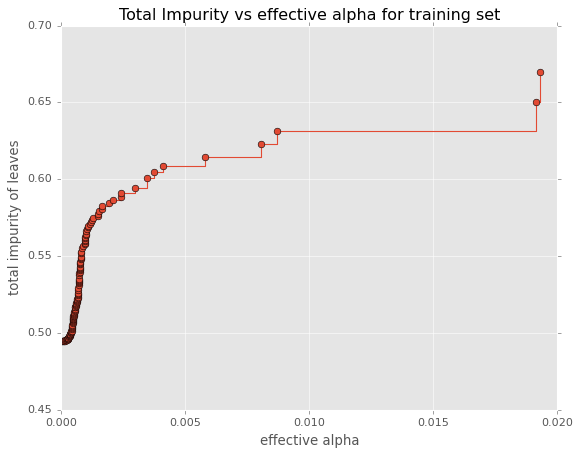

In [44]:
plt.style.use("ggplot")
fig, ax = plt.subplots()
ax.plot(alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()


In [45]:
class_weights = [compute_class_weight('balanced',classes= y.AwayGoals.unique(), y = y.iloc[:,1]),
               compute_class_weight('balanced',classes= y.HomeGoals.unique(), y = y.iloc[:,0])]
class_h = dict(zip(y.HomeGoals.cat.categories,class_weights[0]))
class_a = dict(zip(ytrain.AwayGoals.cat.categories[:-1],class_weights[1][:-1]));print(class_a) 
#to avoid error, not counting weight for '9' category as it doesn't show up in ytrain, but does in ytest. 

{'0': 0.870561282932417, '1': 0.3460837887067395, '2': 0.4944054124381993, '3': 18.357487922705314, '4': 0.4472693032015066, '5': 2.176403207331042, '6': 5.94679186228482, '7': 84.44444444444444}


In [46]:
def fit_models(i, alphas, wt, featureimp=False): 
    treeList = []
    for a in alphas:
        tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5,random_state=0, ccp_alpha=a, class_weight= wt)
        tree.fit(xtrain, ytrain.iloc[:,i]) # model for home goals
        treeList.append(tree)
    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(\
      treeList[-1].tree_.node_count, alphas[-1]))

    treeList = treeList[:-1]
    alphas = alphas[:-1]

    node_counts = [tree.tree_.node_count for tree in treeList]
    depth = [tree.tree_.max_depth for tree in treeList]

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(alphas, depth, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [tree.score(xtrain, ytrain.iloc[:,i]) for tree in treeList]
    test_scores = [tree.score(xtest, ytest.iloc[:,i]) for tree in treeList]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
    ax.plot(alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
    ax.legend()
    plt.show()
    
    bestTreeModel=treeList[np.argmin(impurities)]
    #print({'best trees params': bestTreeModel.get_params()})
    y_pred=bestTreeModel.predict(xtest)
    print("Number of mislabeled points out of a total %d points : %d" % (xtest.shape[0], (ytest.iloc[:,i] != y_pred).sum()))
    C1=confusion_matrix(ytest.iloc[:,i],y_pred)
    bestTreeRate1=1.-np.sum(np.diag(C1))/C1.sum()
    if (i==0):
        print("Error rate on test data for home goals prediction %5.3f"% bestTreeRate1)
    else: print("Error rate on test data for away goals prediction %5.3f"% bestTreeRate1)
    y_pred=bestTreeModel.predict(xtest)
    predProb=bestTreeModel.predict_proba(xtest)

    if (i==0):
        print("home goal predictions\n",classification_report(ytest.iloc[:,i],y_pred, zero_division=0))
    else: print("away goal predictions\n",classification_report(ytest.iloc[:,i],y_pred, zero_division=0))
    print("The confusion matrix for home goals:\n", C1)
    sns.heatmap(C1, annot=True)
    plt.title('observe diagnal')
    plt.show()
    print("Accuracy : %5.3f"% (sum(np.diag(C1))/C1.sum()))
    print("Error rate: %5.3f"%   (1.-sum(np.diag(C1))/C1.sum()))
    
    if featureimp== True:
        importanceDict={xtrain.columns[i]: bestTreeModel.feature_importances_[i]\
                    for i in range(len(xtrain.columns))}
        print("importance of features and their scores\n")
        print(*(f"{term}: {importanceDict[term]:5.3}\n"  for term in importanceDict ))
        fig3=plt.figure()
        sub=fig3.add_subplot(1,1,1)
        #plt.barh(importanceDict.keys(), importanceDict.values(),)
        plt.barh(range(len(xtrain.columns)), bestTreeModel.feature_importances_,align='center')
        plt.yticks(ticks = np.arange(0,100,10))
        plt.title("Importance of features in the best tree from pruning")
        plt.show()
    

Number of nodes in the last tree is: 5 with ccp_alpha: 0.07667307701620996


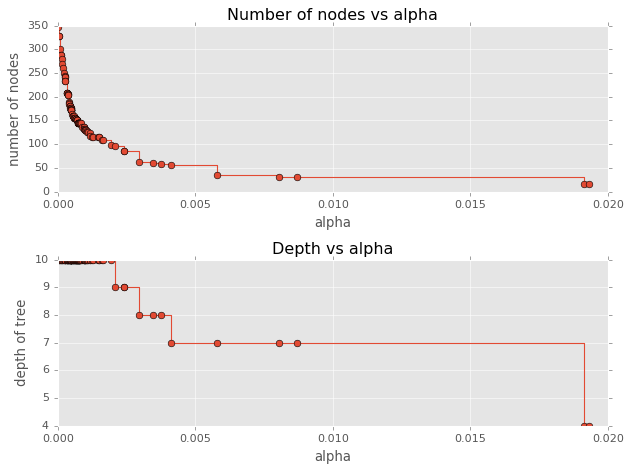

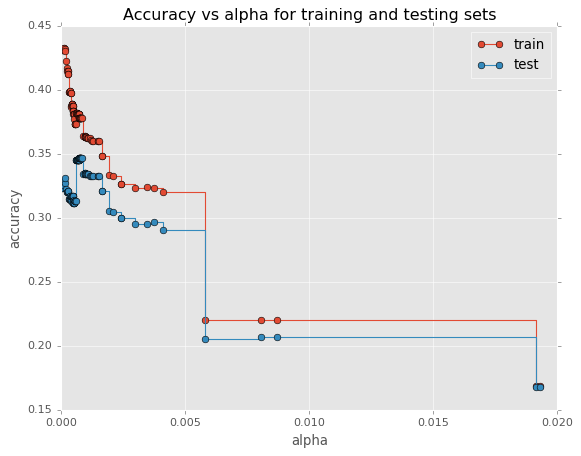

Number of mislabeled points out of a total 950 points : 643
Error rate on test data for home goals prediction 0.677
home goal predictions
               precision    recall  f1-score   support

           0       0.80      0.26      0.39       218
           1       0.32      0.17      0.23       299
           2       0.31      0.81      0.45       235
           3       0.00      0.00      0.00       124
           4       0.06      0.02      0.03        44
           5       0.11      0.24      0.15        21
           6       0.07      0.33      0.12         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2

    accuracy                           0.32       950
   macro avg       0.19      0.20      0.15       950
weighted avg       0.37      0.32      0.28       950

The confusion matrix for home goals:
 [[ 56  83  78   0   0   1   0   0   0]
 [ 14  52 217   0   6   7   3   0   0]
 [  0  20 191   0   3  12   9   0   0]
 

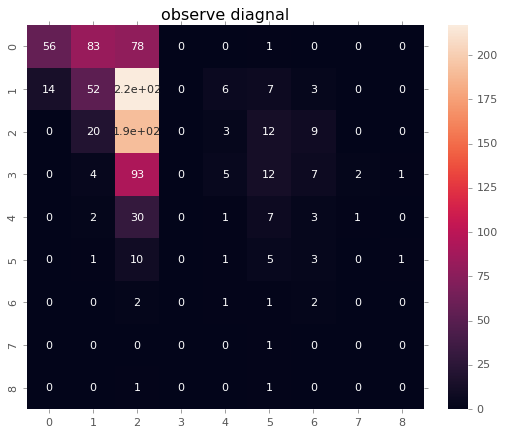

Accuracy : 0.323
Error rate: 0.677


In [47]:
fit_models(0, alphas, class_h)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07667307701620996


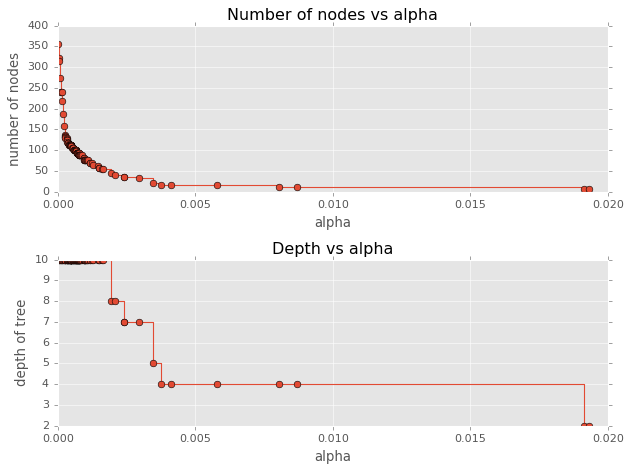

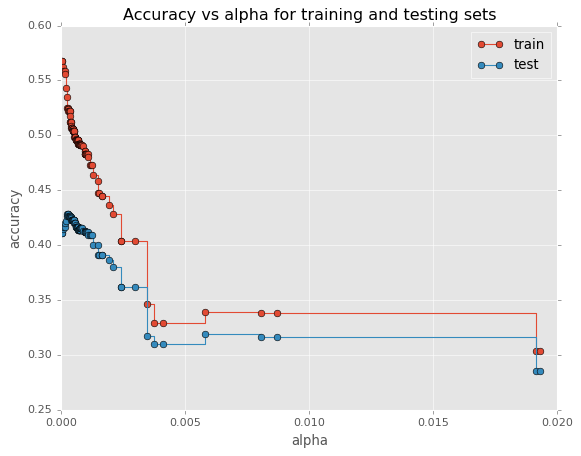

Number of mislabeled points out of a total 950 points : 560
Error rate on test data for away goals prediction 0.589
away goal predictions
               precision    recall  f1-score   support

           0       0.53      0.84      0.65       287
           1       0.51      0.17      0.26       343
           2       0.30      0.09      0.13       185
           3       0.24      0.73      0.36        98
           4       0.00      0.00      0.00        26
           5       0.08      0.12      0.10         8
           6       0.12      0.33      0.18         3
           7       0.00      0.00      0.00         0

    accuracy                           0.41       950
   macro avg       0.22      0.29      0.21       950
weighted avg       0.43      0.41      0.35       950

The confusion matrix for home goals:
 [[241  25   0  21   0   0   0   0]
 [168  59  29  84   0   2   1   0]
 [ 42  28  16  92   0   3   3   1]
 [  7   3   9  72   0   5   0   2]
 [  1   0   0  20   0   1   3   

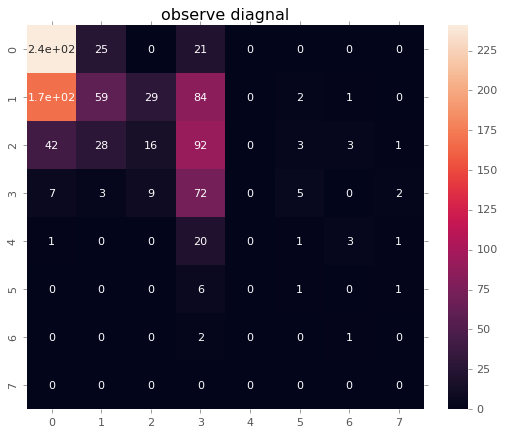

Accuracy : 0.411
Error rate: 0.589
importance of features and their scores

HomeShots: 0.0581
 HomeShotsOnTarget: 0.0986
 HomeCorners: 0.0488
 HomeFouls: 0.0325
 HomeYellowCards: 0.00784
 HomeRedCards:   0.0
 AwayShots: 0.0291
 AwayShotsOnTarget: 0.183
 AwayCorners: 0.00362
 AwayFouls: 0.0228
 AwayYellowCards: 0.0113
 AwayRedCards:   0.0
 H_Arsenal: 0.00141
 H_Aston Villa:   0.0
 H_Birmingham:   0.0
 H_Blackburn: 0.000685
 H_Blackpool:   0.0
 H_Bolton:   0.0
 H_Bournemouth:   0.0
 H_Brighton:   0.0
 H_Burnley:   0.0
 H_Cardiff:   0.0
 H_Chelsea: 0.00051
 H_Crystal Palace: 0.00211
 H_Everton: 0.000106
 H_Fulham: 0.00165
 H_Huddersfield:   0.0
 H_Hull:   0.0
 H_Leicester:   0.0
 H_Liverpool:   0.0
 H_Man City:   0.0
 H_Man United:   0.0
 H_Middlesbrough:   0.0
 H_Newcastle:   0.0
 H_Norwich: 0.000758
 H_QPR:   0.0
 H_Reading:   0.0
 H_Sheffield United:   0.0
 H_Southampton:   0.0
 H_Stoke: 0.00789
 H_Sunderland: 0.00182
 H_Swansea:   0.0
 H_Tottenham:   0.0
 H_Watford:   0.0
 H_West Brom

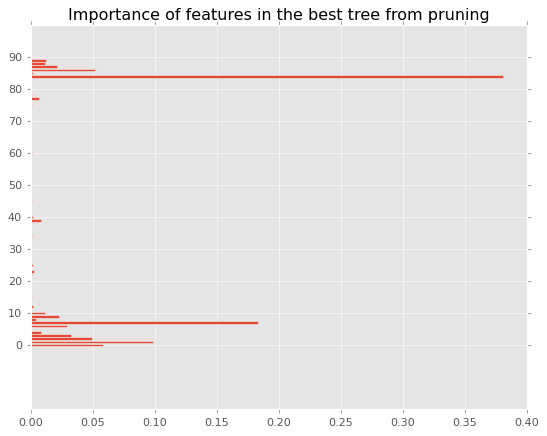

In [48]:
fit_models(1,alphas, class_a, True)

### Predicting goals as a One hot variable. 

In [49]:
y = pd.get_dummies(data = y, drop_first=False)
y.head()

,HomeGoals_0,HomeGoals_1,HomeGoals_2,HomeGoals_3,HomeGoals_4,HomeGoals_5,HomeGoals_6,HomeGoals_7,HomeGoals_8,AwayGoals_0,AwayGoals_1,AwayGoals_2,AwayGoals_3,AwayGoals_4,AwayGoals_5,AwayGoals_6,AwayGoals_7,AwayGoals_9
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [50]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y)

In [51]:
display(xtrain.head(1),\
ytrain.head(1))

,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,...,A_West Brom,A_West Ham,A_Wigan,A_Wolves,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
646,25,19,7,7,1,0,8,3,7,9,...,0,0,0,1,0,0,1,0,0,1


,HomeGoals_0,HomeGoals_1,HomeGoals_2,HomeGoals_3,HomeGoals_4,HomeGoals_5,HomeGoals_6,HomeGoals_7,HomeGoals_8,AwayGoals_0,AwayGoals_1,AwayGoals_2,AwayGoals_3,AwayGoals_4,AwayGoals_5,AwayGoals_6,AwayGoals_7,AwayGoals_9
646,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [52]:
#classwt = compute_class_weight()

In [53]:
tree = DecisionTreeClassifier(min_samples_leaf=5, max_depth=13)
treemodel = tree.fit(xtrain, ytrain)

In [54]:
ypred = treemodel.predict(xtest)

In [55]:
display(ypred[:3],ytest[:3])

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],
      dtype=uint8)

,HomeGoals_0,HomeGoals_1,HomeGoals_2,HomeGoals_3,HomeGoals_4,HomeGoals_5,HomeGoals_6,HomeGoals_7,HomeGoals_8,AwayGoals_0,AwayGoals_1,AwayGoals_2,AwayGoals_3,AwayGoals_4,AwayGoals_5,AwayGoals_6,AwayGoals_7,AwayGoals_9
371,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3620,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1902,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [56]:
perf = []
for i in range(len(ytest.columns)):
    c = confusion_matrix(ytest.iloc[:,i], ypred[:,i])
    print(f"Accuracy for {ytest.columns[i]} :{(sum(np.diag(c))/c.sum()):3.2}")
    print(f"Error rate: %5.3f"%   (1.-sum(np.diag(c))/c.sum()),"\n")
    perf.append(dict(zip(ytest.columns[i]+f'{i}',[c])))

Accuracy for HomeGoals_0 :0.81
Error rate: 0.186 

Accuracy for HomeGoals_1 :0.66
Error rate: 0.344 

Accuracy for HomeGoals_2 :0.73
Error rate: 0.275 

Accuracy for HomeGoals_3 :0.84
Error rate: 0.158 

Accuracy for HomeGoals_4 :0.94
Error rate: 0.061 

Accuracy for HomeGoals_5 :0.99
Error rate: 0.015 

Accuracy for HomeGoals_6 :0.99
Error rate: 0.006 

Accuracy for HomeGoals_7 :1.0
Error rate: 0.002 

Accuracy for HomeGoals_8 :1.0
Error rate: 0.003 

Accuracy for AwayGoals_0 :0.76
Error rate: 0.238 

Accuracy for AwayGoals_1 :0.66
Error rate: 0.339 

Accuracy for AwayGoals_2 :0.77
Error rate: 0.227 

Accuracy for AwayGoals_3 :0.89
Error rate: 0.112 

Accuracy for AwayGoals_4 :0.97
Error rate: 0.027 

Accuracy for AwayGoals_5 :0.99
Error rate: 0.005 

Accuracy for AwayGoals_6 :1.0
Error rate: 0.004 

Accuracy for AwayGoals_7 :1.0
Error rate: 0.000 

Accuracy for AwayGoals_9 :1.0
Error rate: 0.001 



In [59]:
print(classification_report(ytest, ypred, zero_division=0))

              precision    recall  f1-score   support

           0       0.62      0.50      0.56       220
           1       0.48      0.35      0.40       318
           2       0.37      0.31      0.34       213
           3       0.32      0.15      0.20       128
           4       0.13      0.04      0.06        47
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.68      0.60      0.64       331
          10       0.45      0.32      0.38       302
          11       0.39      0.24      0.29       191
          12       0.32      0.18      0.23        88
          13       0.75      0.11      0.19        28
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         0
          17       0.00    